<a href="https://colab.research.google.com/github/manuprasad-cybera/Automatic_Ticket_Classification_Assignment/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import time
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Opening JSON file
# Write the path to your data file and load it

# returns JSON object as
f = open('/content/drive/MyDrive/Automatic_Ticket_Classification_Assignment/complaints-2021-05-14_08_16.json')
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
df.shape

(78313, 22)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [12]:
#print the column names
new_col = list(df.columns)
for i in range(len(new_col)):
  new_col[i] = new_col[i].lstrip('_')
  if 'source.' in new_col[i]:
    new_col[i] = new_col[i][7:]
new_col

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [13]:
#Assign new column names
df.columns = new_col
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [15]:
#Assign nan in place of blanks in the complaints column
df.isna().sum()


fill_empty_complaints = df[df['complaint_what_happened'] == '']

In [16]:
#Assign nan in place of blanks in the complaints column
fill_empty_complaints.loc[::,['complaint_what_happened']] = 'NaN'
df[df['complaint_what_happened']== ''] = fill_empty_complaints

In [17]:
#Remove all rows where complaints column is nan
df = df[~(df['complaint_what_happened']=='NaN')]
df.shape

(21072, 22)

In [18]:
df['complaint_what_happened'].head()

,complaint_what_happened
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,Chase Card was reported on XX/XX/2019. However...
11,"On XX/XX/2018, while trying to book a XXXX XX..."
14,my grand son give me check for {$1600.00} i de...


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [19]:
# Write your function here to clean the text and remove all the unnecessary elements.
from nltk import pos_tag
def clean_text(text):
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    return lemmatized_tokens

def filter_pos_tags(tokens):
    tagged_tokens = pos_tag(tokens)
    filtered_tokens = [token[0] for token in tagged_tokens if token[1] == 'NN']
    return filtered_tokens

In [25]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng') # Download the 'eng' specific model

# Rest of your existing code
from nltk import pos_tag
# ... (rest of the functions)

import nltk
sentence =''
sent = []
lem_sentence =''
lem_sent =[]
for i in df['complaint_what_happened']:
    clean_sentence = clean_text(i)
    lemmatized_sentence = lemmatize_text(clean_sentence)
    lem_sentence = ' '.join(lemmatized_sentence)
    lem_sent.append(lem_sentence)
    filtered_tokens = filter_pos_tags(lemmatized_sentence)

    sentences = ' '.join(filtered_tokens)
    sent.append(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [26]:
len(lem_sent)

21072

In [27]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame({'Original Complaints':df['complaint_what_happened'],'Lemmatized Complaints':lem_sent, 'Complaints_POS_removed':sent})
df_clean.head()

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...


In [28]:
df_clean.head()

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...


In [30]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




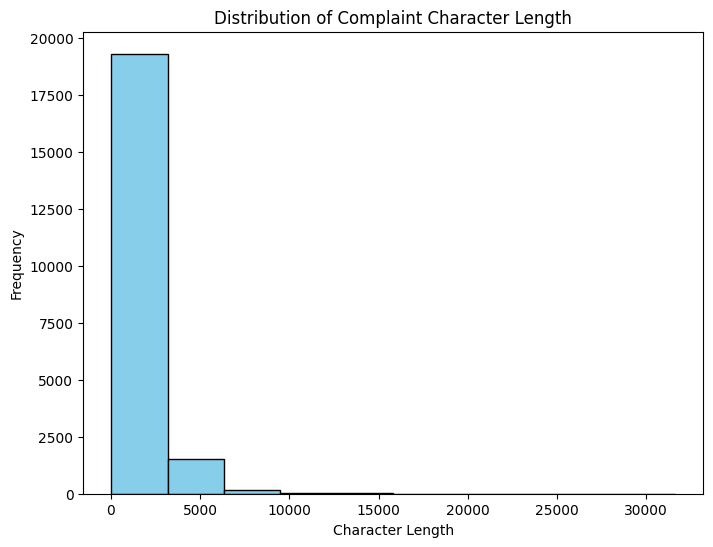

In [32]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['Length'] = df_clean['Original Complaints'].apply(len)

# Plotting
plt.figure(figsize=(8, 6))
plt.hist(df_clean['Length'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Character Length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

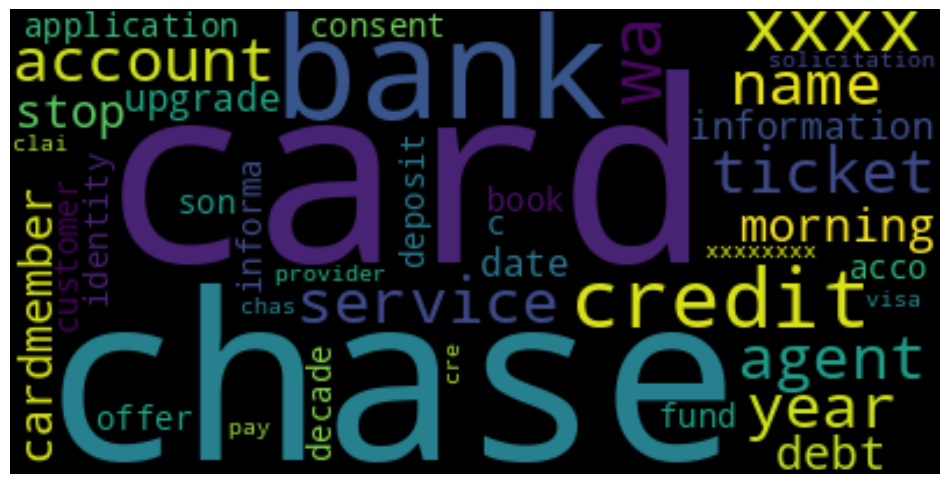

In [33]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['Complaints_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [34]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['Complaints_POS_removed'].str.replace('-PRON-', '')
df_clean['Length_without_pron'] = df_clean['Complaint_clean'].apply(len)
df_clean['Length_pos'] = df_clean['Complaints_POS_removed'].apply(len)
df_clean.head()

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,Length,Complaint_clean,Length_without_pron,Length_pos
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,153,153
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,i card agent upgrade date agent wa information...,103,103
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,card wa application identity consent service c...,70,70
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,book xxxx ticket i offer ticket card i informa...,434,434
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,170,170


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [35]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
import nltk
from nltk.corpus import stopwords
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['Complaints_POS_removed'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_ngram

In [37]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
df_unigram = top_grams(1)
df_unigram.head(10)

,frequency,unigram
0,51079,chase
1,47645,account
2,38368,xxxx
3,33094,credit
4,32996,wa
5,29587,card
6,28233,bank
7,21167,payment
8,16038,time
9,12972,day


In [38]:
#Print the top 10 words in the unigram frequency

In [39]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
df_bigram = top_grams(2)
df_bigram.head(10)

,frequency,unigram
0,12824,credit card
1,4101,xxxx xxxx
2,3876,credit report
3,3085,customer service
4,3085,chase credit
5,2948,chase account
6,2850,account wa
7,2823,chase bank
8,2814,bank account
9,2768,account chase


In [41]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
df_trigram = top_grams(3)
df_trigram.head(10)

,frequency,unigram
0,2116,chase credit card
1,1049,credit card account
2,987,credit card company
3,683,credit card chase
4,516,inquiry credit report
5,476,credit card credit
6,423,xxxx xxxx xxxx
7,405,account credit card
8,388,credit reporting agency
9,384,bank credit card


In [43]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [45]:
df_clean['Complaints_POS_removed'] = df_clean['Complaints_POS_removed'].str.replace('xxxx','')

In [47]:
#All masked texts has been removed
df_clean

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,Length,Complaint_clean,Length_without_pron,Length_pos
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,153,153
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,i card agent upgrade date agent wa information...,103,103
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,card wa application identity consent service c...,70,70
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book ticket i offer ticket card i information...,1502,book ticket i offer ticket card i information...,434,434
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,170,170
...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,679,chase card customer decade wa solicitation cre...,234,234
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,i chas visa credit card provider claim purcha...,2114,i chas visa credit card provider claim purcha...,682,682
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2319,i pay risk consumer i bank app chase year mobi...,707,707
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom problem ba...,2171,i credit credit card chase freedom problem ba...,510,510


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [48]:
#Write your code here to initialise the TfidfVectorizer
tf_idf = TfidfVectorizer(min_df = 2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [50]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dt_matrix = tf_idf.fit_transform(df_clean['Complaints_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [52]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [54]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5#write the value you want to test out

#keep the random_state =40
nmf_model =  NMF(random_state=40,n_components=num_topics) #write your code here

In [55]:
nmf_model.fit(dt_matrix)
len(tf_idf.get_feature_names_out())

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



6966

In [56]:
#Print the Top15 words for each of the topics

words = np.array(tf_idf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,chase,fund,wa,deposit,branch,day,transaction,number,business,checking,claim
Topic 2,card,charge,chase,credit,wa,dispute,transaction,purchase,fraud,merchant,service,fee,time,claim,company
Topic 3,payment,balance,fee,month,statement,wa,day,time,date,auto,credit,chase,account,year,error
Topic 4,credit,report,inquiry,card,account,score,bureau,company,debt,reporting,information,limit,application,chase,identity
Topic 5,loan,mortgage,chase,home,modification,property,year,wa,letter,rate,time,document,foreclosure,bank,house


In [57]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dt_matrix)
topic_results.argmax(axis=1)

array([0, 1, 3, ..., 1, 2, 2])

In [84]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [85]:
df_clean.head()

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,Length,Complaint_clean,Length_without_pron,Length_pos,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,153,153,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,i card agent upgrade date agent wa information...,103,103,1
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,card wa application identity consent service c...,70,70,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book ticket i offer ticket card i information...,1502,book ticket i offer ticket card i information...,434,434,3
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,170,170,0


In [86]:
#Print the first 5 Complaint for each of the Topics
df_clean.sort_values('Topic')
df_clean.groupby('Topic').head()

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,Length,Complaint_clean,Length_without_pron,Length_pos,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,153,153,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,i card agent upgrade date agent wa information...,103,103,1
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,card wa application identity consent service c...,70,70,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book ticket i offer ticket card i information...,1502,book ticket i offer ticket card i information...,434,434,3
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,170,170,0
15,Can you please remove inquiry,can you please remove inquiry,inquiry,29,inquiry,7,7,3
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday thursday b...,2277,jp chase account debit card tuesday thursday b...,647,647,0
20,"During the summer months, I experience a decli...",during the summer month i experience a decline...,summer month i income employment month payment...,1396,summer month i income employment month payment...,600,600,2
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx i made a payment to an online retailer...,i payment retailer pay chase website i scam ...,3541,i payment retailer pay chase website i scam ...,1175,1175,1
23,I have a Chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,129,chase credit card credit report company issue,45,45,3


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [107]:
# Create the dictionary of Topic names and Topics
topic_results = nmf_model.transform(dt_matrix)  # Apply your topic model to get topic probabilities
topic_numbers = topic_results.argmax(axis=1) # Assign topic numbers based on probabilities
df_clean['Topic_Number'] = topic_numbers  # Add a new column for topic numbers
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
# Map topic numbers to names using the dictionary
df_clean['Topic'] = df_clean['Topic_Number'].map(Topic_names)

In [108]:
df_clean

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,Length,Complaint_clean,Length_without_pron,Length_pos,Topic,Topic_Number
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,153,153,Account Services,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,i card agent upgrade date agent wa information...,103,103,Others,1
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,card wa application identity consent service c...,70,70,Credit card or prepaid card,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book ticket i offer ticket card i information...,1502,book ticket i offer ticket card i information...,434,434,Credit card or prepaid card,3
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,170,170,Account Services,0
...,...,...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,679,chase card customer decade wa solicitation cre...,234,234,Others,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,i chas visa credit card provider claim purcha...,2114,i chas visa credit card provider claim purcha...,682,682,Others,1
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2319,i pay risk consumer i bank app chase year mobi...,707,707,Others,1
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom problem ba...,2171,i credit credit card chase freedom problem ba...,510,510,Mortgage/Loan,2


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [109]:
# Create the dictionary of Topic names and Topics
Topic_names = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(Topic_names)


<ipython-input-109-a8c617cda590>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [110]:
df_clean.shape

(21072, 9)

In [95]:
df['Topic'] = df_clean['Topic']

In [105]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['Complaints_POS_removed','Topic']]

In [111]:
training_data

,Complaints_POS_removed,Topic
1,morning name stop bank cardmember service debt...,0
2,i card agent upgrade date agent wa information...,1
10,card wa application identity consent service c...,3
11,book ticket i offer ticket card i information...,3
14,son deposit chase account fund chase bank acco...,0
...,...,...
78303,chase card customer decade wa solicitation cre...,1
78309,i chas visa credit card provider claim purcha...,1
78310,i pay risk consumer i bank app chase year mobi...,1
78311,i credit credit card chase freedom problem ba...,2


In [112]:
df_clean.shape

(21072, 9)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [113]:
# Write your code to get the Vector count
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['Complaints_POS_removed'])

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [114]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report




# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

Logistic Regression

In [115]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1180
           1       0.96      0.98      0.97      1156
           2       0.98      0.93      0.96       495
           3       0.98      0.96      0.97       658
           4       0.95      0.96      0.95       726

    accuracy                           0.97      4215
   macro avg       0.97      0.96      0.96      4215
weighted avg       0.97      0.97      0.97      4215



 Decision Tree

In [116]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
dt_predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1180
           1       0.96      0.98      0.97      1156
           2       0.98      0.93      0.96       495
           3       0.98      0.96      0.97       658
           4       0.95      0.96      0.95       726

    accuracy                           0.97      4215
   macro avg       0.97      0.96      0.96      4215
weighted avg       0.97      0.97      0.97      4215



In [117]:
dt_d7 = DecisionTreeClassifier(max_depth = 7).fit(X_train, y_train)
dt_predicted_d7 = dt_d7.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1180
           1       0.96      0.98      0.97      1156
           2       0.98      0.93      0.96       495
           3       0.98      0.96      0.97       658
           4       0.95      0.96      0.95       726

    accuracy                           0.97      4215
   macro avg       0.97      0.96      0.96      4215
weighted avg       0.97      0.97      0.97      4215



Random Forest Classifier

In [118]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.64      0.93      0.76      1180
           1       0.64      0.89      0.75      1156
           2       1.00      0.01      0.03       495
           3       0.90      0.38      0.54       658
           4       0.85      0.72      0.78       726

    accuracy                           0.69      4215
   macro avg       0.81      0.59      0.57      4215
weighted avg       0.76      0.69      0.64      4215



 Naive Bayes

In [119]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.43      0.23      0.30      1180
           1       0.55      0.22      0.32      1156
           2       0.17      0.31      0.22       495
           3       0.26      0.71      0.38       658
           4       0.52      0.35      0.42       726

    accuracy                           0.33      4215
   macro avg       0.39      0.36      0.33      4215
weighted avg       0.42      0.33      0.33      4215



We can see that the Logistic Regression have the best accuracy than other models so we will check the prediction

In [120]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [128]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [122]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Theft/Dispute Reporting
1,The bill amount of my credit card was debited ...,Others
2,I want to open a salary account at your downto...,Account Services
3,"Yesterday, I received a fraudulent email regar...",Others
4,What is the procedure to know my CIBIL score?,Theft/Dispute Reporting
5,I need to know the number of bank branches and...,Account Services


Conclusion

    As expected 5 topics were indetified namely:
        Account Services
        Others
        Mortgage/Loan
        Credit card or prepaid card
        Theft/Dispute Reporting

    Tried 4 models on the data with accuracies as follows:

    | Model | Accuracy |
    | ----------- | ----------- |
    | Logistic Regression | 0.97 |
    | Decision Tree | 0.97 |
    | Random Forest | 0.69 |
    | Naive Bayes | 0.33 |


